In [1]:
import mysql_auth 
from MySQLConnection import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from Modeling import *

In [2]:
# conn = MySQLConnection(DB_info=mysql_auth.NYXL_DB_Match_FinalStat)
# input_df = conn.read_all_tables_as_df()
input_df = pd.read_csv('input_df.csv')
display(input_df)

C:\Users\jyc13\anaconda3\envs\owl-data\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (6,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,MatchId,num_map,Map,map_type,Section,RoundName,Timestamp,Team,Player,...,OffensiveAssists/s,RCP,FBValue,DeathRisk,TF_order,TF_winner,TF_duration,TF_RCP_sum,TF_RCP_weighted_sum,DominanceIndex
0,0,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Doha,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
1,1,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Fielder,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
2,2,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Jecse,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
3,3,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Crimzo,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
4,4,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Happy,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485317,2485317,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,Dreamer,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485318,2485318,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,Happy,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485319,2485319,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,joobi,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485320,2485320,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,joobi,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838


In [3]:
input_df['position_x'] = input_df['position'].str.split(',').str[0].astype('float')
input_df['position_y'] = input_df['position'].str.split(',').str[2].astype('float')
input_df['position_z'] = input_df['position'].str.split(',').str[1].astype('float')

In [4]:
def get_distance_from_center(input_df):
    input_df[['position_x_norm', 'position_y_norm', 'position_z_norm']] = input_df.groupby(['MatchId', 'num_map', 'Section'])[['position_x', 'position_y', 'position_z']].apply(lambda x: (x - x.min()) / (x.max() - x.min()) )
    avg_position_x = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_x_norm']].mean()
    avg_position_y = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_y_norm']].mean()
    avg_position_z = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_z_norm']].mean()

    input_df = input_df.set_index(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])

    df_merge = pd.merge(input_df, avg_position_x, left_index=True, right_index=True, suffixes=('', '_avg'))
    df_merge = pd.merge(df_merge, avg_position_y, left_index=True, right_index=True, suffixes=('', '_avg'))
    df_merge = pd.merge(df_merge, avg_position_z, left_index=True, right_index=True, suffixes=('', '_avg'))

    df_merge.dropna(axis=0, how='any', inplace=True)
    df_merge['distance_from_center'] = ((df_merge['position_x_norm_avg'] - df_merge['position_x_norm'])**2 + (df_merge['position_y_norm_avg'] - df_merge['position_y_norm'])**2 + (df_merge['position_z_norm_avg'] - df_merge['position_z_norm'])**2)**(1/2)

    output_df = df_merge.reset_index()
    return output_df

In [5]:
input_df = get_distance_from_center(input_df)

In [6]:
from scipy.spatial import ConvexHull

def ConvHullArea(X):
    # X = X[X.loc[:,'IsAlive']==1]
    X = X[X['IsAlive']==1]
    points = X.iloc[:,1:3].values
    try:
        hull = ConvexHull(points)
        area = hull.area
    except: 
        area = 0
    return area

df_points = input_df.groupby(['MatchId', 'num_map', 'Map', 'Section', 'Timestamp', 'Team'])[['IsAlive', 'position_x', 'position_y']].apply(ConvHullArea)

df_points = df_points.reset_index()
df_points.rename(columns={0:'ConvHullArea'}, inplace=True)

df_merge = pd.merge(input_df, df_points, how='outer', on=['MatchId', 'num_map', 'Map', 'Section', 'Timestamp', 'Team'])

In [7]:
selected_features = [
    'TimePlayed/s', 'HeroDamageDealt/s', 'BarrierDamageDealt/s', 'HeroDamageTaken/s', 'HealingDealt/s', 'HealingReceived/s', 'EnvironmentalDeaths/s', 'EnvironmentalKills/s', 'SoloKills/s', 'UltimatesUsed/s', 'distance_from_center', 'ConvHullArea'
]
selected_features = ['distance_from_center', 'ConvHullArea']

In [8]:
df_init = df_merge[df_merge['TF_order'].notna()]
df_init['IsTFWinner'] = df_init['Team'] == df_init['TF_winner'] # TF_winner
df_init['IsMapWinner'] = df_init['Team'] == df_init['MapWinner'] # Map_winner
target_flag = 'Teamfight' # Map or Teamfight

if target_flag == 'Map':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Team']
    target = 'IsMapWinner'
elif target_flag == 'Teamfight':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Section', 'TF_order', 'Team']
    target = 'IsTFWinner'

df_init['HeroComp'] = df_init['Hero']
df_init = pd.get_dummies(data=df_init, columns=['HeroComp'], prefix='Hero')
df_init = df_init[df_init['TimePlayed/s'] != 0]
df_X = df_init.groupby(grouping_index)[selected_features + [x for x in df_init.columns if x.startswith('Hero_')] + [target]].sum()
# df_X = df_init.groupby(grouping_index)[selected_features + [x for x in df_init.columns if x.startswith('Hero_')] + [target]].first()

df_X.replace({False:0, True:1}, inplace=True)
df_X.loc[df_X[target] != 0, target] = 1
hero_col = [x for x in df_X.columns if x.startswith('Hero_')]
for col in hero_col:
    df_X.loc[df_X[col] != 0, col] = 1

df_y = df_X[target]
df_X = df_X.drop(target, axis=1)

df_X_norm = df_X.groupby([x for x in grouping_index if x != 'Team']).apply(lambda x: x/x.sum()) # 팀 상대적으로 비교하기 위해 normalization
df_X_norm = df_X_norm.fillna(0)

display(df_X_norm)
display(df_y)

distance_from_center  \
MatchId num_map Map   Section TF_order Team                                    
37147   1       Busan 1.0     1.0      Dallas Fuel                  0.373529   
                                       Houston Outlaws              0.626471   
                              2.0      Dallas Fuel                  0.472528   
                                       Houston Outlaws              0.527472   
                              3.0      Dallas Fuel                  0.411188   
...                                                                      ...   
37404   1       Busan 2.0     1.0      Houston Outlaws              0.488971   
                              2.0      Dallas Fuel                  0.427752   
                                       Houston Outlaws              0.572248   
                              3.0      Dallas Fuel                  0.414433   
                                       Houston Outlaws              0.585567   

                                                        ConvHullArea  \
MatchId num_map Map   Section TF_order Team                            
37147   1       Busan 1.0     1.0      Dallas Fuel          0.414811   
                                       Houston Outlaws      0.585189   
                              2.0      Dallas Fuel          0.567311   
                                       Houston Outlaws      0.432689   
                              3.0      Dallas Fuel          0.475324   
...                                                              ...   
37404   1       Busan 2.0     1.0      Houston Outlaws      0.349552   
                              2.0      Dallas Fuel          0.432575   
                                       Houston Outlaws      0.567425   
                              3.0      Dallas Fuel          0.433403   
                                       Houston Outlaws      0.566597   

                                                        Hero_Ana  Hero_Ashe  \
MatchId num_map Map   Section TF_order Team                                   
37147   1       Busan 1.0     1.0      Dallas Fuel           0.0        0.0   
                                       Houston Outlaws       1.0        0.0   
                              2.0      Dallas Fuel           0.0        0.0   
                                       Houston Outlaws       1.0        0.0   
                              3.0      Dallas Fuel           0.0        0.0   
...                                                          ...        ...   
37404   1       Busan 2.0     1.0      Houston Outlaws       0.0        0.0   
                              2.0      Dallas Fuel           0.0        0.0   
                                       Houston Outlaws       0.0        0.0   
                              3.0      Dallas Fuel           0.0        0.0   
                                       Houston Outlaws       0.0        0.0   

                                                        Hero_Baptiste  \
MatchId num_map Map   Section TF_order Team                             
37147   1       Busan 1.0     1.0      Dallas Fuel                0.0   
                                       Houston Outlaws            0.0   
                              2.0      Dallas Fuel                0.0   
                                       Houston Outlaws            0.0   
                              3.0      Dallas Fuel                0.0   
...                                                               ...   
37404   1       Busan 2.0     1.0      Houston Outlaws            1.0   
                              2.0      Dallas Fuel                0.0   
                                       Houston Outlaws            1.0   
                              3.0      Dallas Fuel                0.0   
                                       Houston Outlaws            1.0   

                                                        Hero_Bastion  \
MatchId num_map Map   Sectio

MatchId  num_map  Map    Section  TF_order  Team           
37147    1        Busan  1.0      1.0       Dallas Fuel        1
                                            Houston Outlaws    0
                                  2.0       Dallas Fuel        1
                                            Houston Outlaws    0
                                  3.0       Dallas Fuel        1
                                                              ..
37404    1        Busan  2.0      1.0       Houston Outlaws    0
                                  2.0       Dallas Fuel        1
                                            Houston Outlaws    0
                                  3.0       Dallas Fuel        1
                                            Houston Outlaws    0
Name: IsTFWinner, Length: 2570, dtype: int64

In [9]:
X = df_X_norm.values
y = df_y.values
feature_names = df_X_norm.columns 
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
print(X.shape, y.shape)

(2570, 34) (2570,)


In [10]:
dnn = ModelDNN(X=X, y=y) 
dnn.create_model()

X_train shape :  (1721, 34)
y_train shape :  (1721,)
X_test shape :  (849, 34)
y_test shape :  (849,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2240      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                2240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 O

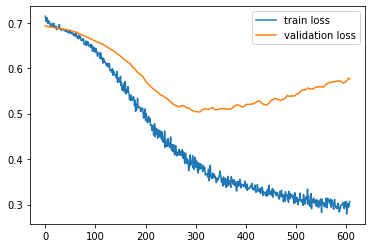

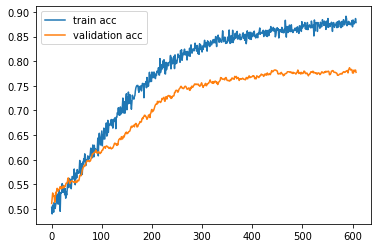

[0.5765038132667542, 0.7773852]

In [11]:
dnn.train_model(num_epoch=30000, batch_size=5000, patience=300, verbose=0)
dnn.model.evaluate(dnn.X_test, dnn.y_test, batch_size=3000, verbose=0)

## SHAP Interpretation

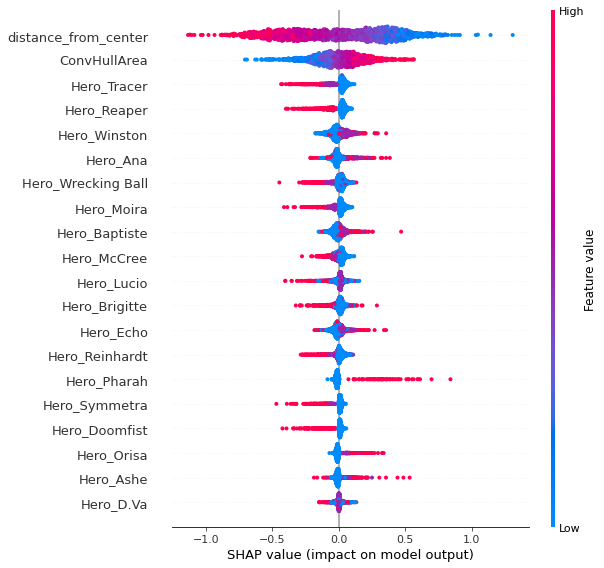

In [12]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model
explainer = shap.GradientExplainer(dnn.model, dnn.X_train)
shap_values = explainer.shap_values(dnn.X_train)

# plot
# shap.summary_plot(shap_values, dnn.X_test, feature_names=feature_names)
shap.summary_plot(shap_values[0], dnn.X_train, feature_names=feature_names)

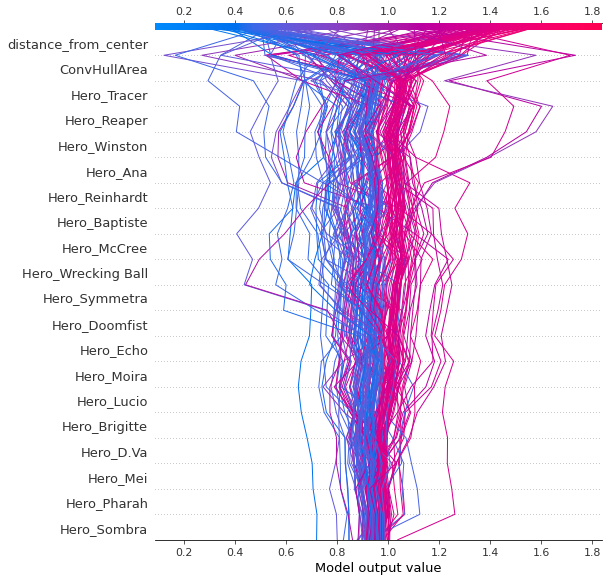

In [13]:
y_hat = dnn.model.predict(dnn.X_train[:150])
shap.decision_plot(y_hat[0], shap_values[0][:150], feature_names)

## 개별 항목 SHAP Explaination

In [14]:
df = df_X.reset_index()
df[df['Team'] == 'New York Excelsior']

,MatchId,num_map,Map,Section,TF_order,Team,distance_from_center,ConvHullArea,Hero_Ana,Hero_Ashe,...,Hero_Soldier: 76,Hero_Sombra,Hero_Symmetra,Hero_Torbjorn,Hero_Tracer,Hero_Widowmaker,Hero_Winston,Hero_Wrecking Ball,Hero_Zarya,Hero_Zenyatta
844,37241,1,Ilios,1.0,1.0,New York Excelsior,41.474246,31967.713366,1,0,...,0,0,0,0,0,0,0,1,0,0
846,37241,1,Ilios,1.0,2.0,New York Excelsior,24.381807,17253.500287,1,0,...,0,0,0,0,1,0,0,1,0,0
848,37241,1,Ilios,1.0,3.0,New York Excelsior,11.719622,9472.279472,1,0,...,0,0,0,0,1,0,0,1,0,0
850,37241,1,Ilios,2.0,1.0,New York Excelsior,10.013748,8046.219450,0,1,...,0,0,0,0,0,0,0,1,0,0
852,37241,1,Ilios,2.0,2.0,New York Excelsior,32.398735,20422.855895,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,37394,1,Oasis,1.0,3.0,New York Excelsior,39.767934,16040.390260,0,0,...,0,0,0,0,0,0,0,1,0,0
2485,37394,1,Oasis,2.0,1.0,New York Excelsior,10.229916,7555.006333,0,0,...,0,0,0,0,0,0,0,0,0,0
2487,37394,1,Oasis,2.0,2.0,New York Excelsior,23.566890,11708.878923,0,0,...,0,0,0,0,0,0,0,0,0,0
2489,37394,1,Oasis,2.0,3.0,New York Excelsior,15.798374,9900.283653,0,0,...,0,0,0,0,0,0,0,0,0,0


(37241, 1, 'Ilios', 1.0, 1.0, 'New York Excelsior') 1 vs  (37241, 1, 'Ilios', 1.0, 1.0, 'Shanghai Dragons') 0


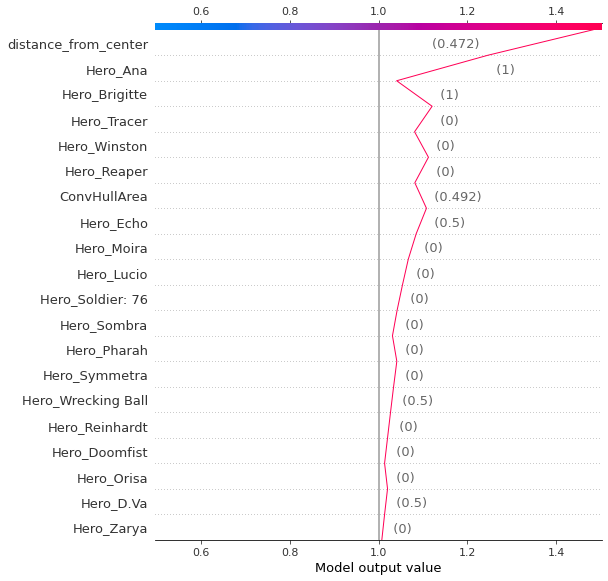

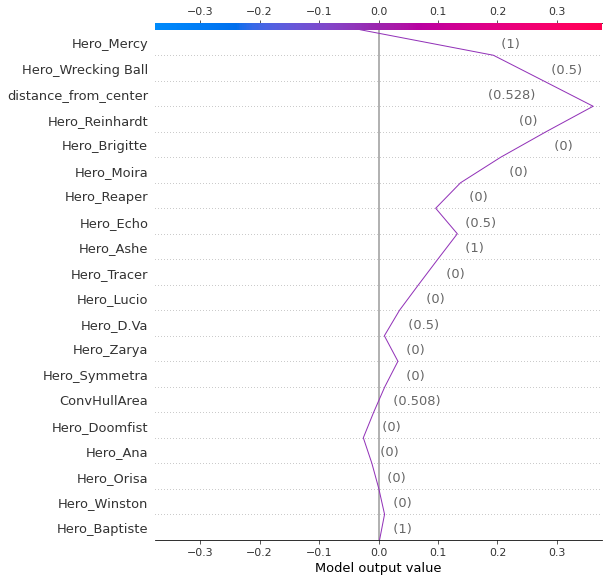

In [15]:
i = 844
if i % 2 == 0: 
    j = i + 1
else: 
    j = i - 1

# inverse_X_train = scaler.inverse_transform(dnn.X_train)

print(df_X_norm.index[i], dnn.y_train[i], 'vs ', df_X_norm.index[j], dnn.y_train[j])
shap.decision_plot(dnn.y_train[i], shap_values[0][i], dnn.X_train[i], feature_names=feature_names.tolist())
shap.decision_plot(dnn.y_train[j], shap_values[0][j], dnn.X_train[j], feature_names=feature_names.tolist())